# Introduction + Background
This is a notebook that generates a ridgeline plot of the laptimes for drivers of the 2020 Hungarian Grand Prix.   
It generated an active discussion on /r/Formula1: https://www.reddit.com/r/formula1/comments/hvcnvo/laptime_distributions_for_the_2020_hungarian/.

Data is available from the [official FIA website](https://www.fia.com/events/fia-formula-one-world-championship/season-2020/hungarian-grand-prix/eventtiming-information), under "Lap Analysis". The license prevents me from distributing the data with this notebook. Sorry :(  
Unfortunately the data has been made available in PDF, instead of something more machine-readable such as CSV, so we'll have to do a little bit of clean-up along the way. 

In [21]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PyPDF2 import PdfFileReader

# Helpers

In [22]:
# Some regex helpers
driver_name = re.compile('([a-zA-Z])+\w ([A-Z])\w+')
lap_time = re.compile('([0-9])+:([0-9])+.([0-9])+')
lap_count = re.compile('([0-9])+')

In [23]:
def clean_up(text):
    """Split a page's text into the table contents and remove unnecessary content"""
    split = text.split('\n')
    smaller_split = [s for s in split if len(s) > 0]
    smaller_split = [s for s in split if s not in [' ', 'LAP', 'TIME', 'Race Lap Analysis', 'P']]
    return smaller_split

In [24]:
def get_driver_indexes(smaller_split):
    """Find the indices in `smaller_split` that contain the driver's name"""
    driver_indexes = []
    for i, s in enumerate(smaller_split):
        if driver_name.match(s):
             driver_indexes.append(i)
    return driver_indexes

In [25]:
def get_driver_lap_times(driver_indexes, smaller_split):
    """Get the laptimes for each driver in `driver_indexes`"""
    data = {}
    for i, driver_idx in enumerate(driver_indexes):
        race_number = smaller_split[driver_idx-1]  # We don't actually use this
        try:
            stop_idx = driver_indexes[i+1]  # Stop before the next driver
        except IndexError:  # When we are at the last driver
            stop_idx = len(smaller_split)-1
        # Only take elements that look like laptimes (skipping over lap numbers)
        lap_times = [x for x in smaller_split[driver_idx+2:stop_idx:2] if lap_time.match(x)]
        data[smaller_split[driver_idx]] = pd.Series(lap_times)  # Make it easy to create a dataframe
    return data



In [26]:
def extract_whole_page(page_text):
    """Extract the laptimes from a single page of text."""
    cleaned_split = clean_up(page_text)
    driver_indexes = get_driver_indexes(cleaned_split)
    data = get_driver_lap_times(driver_indexes, cleaned_split)
    return data

In [27]:
def convert_lap_time_to_seconds(x):
    minutes, seconds = x.split(':')
    return float(minutes)*60 + float(seconds)

# Execution

In [28]:
pdf = PdfFileReader('2020_03_hun_f1_r0_timing_racelapanalysis_v01.pdf')
data = {}
for i in range(pdf.getNumPages()):
    page = pdf.getPage(i)
    text = page.extractText()
    data.update(extract_whole_page(text))

In [29]:
df = pd.DataFrame(data)
df = df.drop(0)  # First row contains start times
df = pd.melt(df, value_vars=df.columns)  # Tidy format
df = df.dropna()

In [30]:
df.head()

,variable,value
0,Daniel RICCIARDO,1:36.511
1,Daniel RICCIARDO,1:35.918
2,Daniel RICCIARDO,1:37.019
3,Daniel RICCIARDO,1:51.736
4,Daniel RICCIARDO,1:27.280


In [31]:
df.tail()

,variable,value
1374,Antonio GIOVINAZZI,1:20.523
1375,Antonio GIOVINAZZI,1:20.411
1376,Antonio GIOVINAZZI,1:20.425
1377,Antonio GIOVINAZZI,1:20.238
1378,Antonio GIOVINAZZI,1:20.616


In [32]:
df['laptime_seconds'] = df['value'].apply(convert_lap_time_to_seconds)
df = df[df['laptime_seconds'] < 95]  # Make things fit

In [33]:
df.head()

,variable,value,laptime_seconds
4,Daniel RICCIARDO,1:27.280,87.280
5,Daniel RICCIARDO,1:25.192,85.192
6,Daniel RICCIARDO,1:23.968,83.968
7,Daniel RICCIARDO,1:23.543,83.543
8,Daniel RICCIARDO,1:23.226,83.226


In [34]:
# Hardcode finishing order to help seaborn arrange the plots correctly
finishing_order = [
    'Lewis HAMILTON',
    'Max VERSTAPPEN',
    'Valtteri BOTTAS',
    'Lance STROLL',
    'Alexander ALBON',
    'Sebastian VETTEL',
    'Sergio PEREZ',
    'Daniel RICCIARDO',
    'Carlos SAINZ',
    'Kevin MAGNUSSEN',
    'Charles LECLERC',
    'Daniil KVYAT',
    'Lando NORRIS',
    'Esteban OCON',
    'Kimi RAIKKONEN',
    'Romain GROSJEAN',
    'Antonio GIOVINAZZI',
    'George RUSSELL',
    'Nicholas LATIFI',
    'Pierre GASLY'
]

In [35]:
# Encode team colours
mercedes = '#01ffcd' #'#00d2be' # <-- official colours from the F1 website, but they look ugly in a plot
redbull = '#0000fe'#'#0600ef'
mclaren = '#ff6600'#'#ff8700'
ferrari = '#fe0000' #'#dc0000'
racing_point = '#ff99cb'#'#f596c8'
renault = '#ffc000' #'#fff500'
alpha_tauri = '#000000'
alfa_romeo = '#960000'
haas = '#787878'
williams = '#0082fa'

colors = [
    mercedes,
    redbull,
    mclaren,
    ferrari,
    racing_point,
    renault,
    alpha_tauri,
    alfa_romeo,
    haas,
    williams
]

In [36]:
team_lookup = {
    'Lewis HAMILTON': 'Mercedes',
    'Max VERSTAPPEN': 'Red Bull',
    'Valtteri BOTTAS': 'Mercedes',
    'Lance STROLL': 'Racing Point',
    'Alexander ALBON': 'Red Bull',
    'Sebastian VETTEL': 'Ferrari',
    'Sergio PEREZ': 'Racing Point',
    'Daniel RICCIARDO': 'Renault',
    'Carlos SAINZ': 'McLaren',
    'Kevin MAGNUSSEN': 'Haas',
    'Charles LECLERC': 'Ferrari',
    'Daniil KVYAT': 'AlphaTauri',
    'Lando NORRIS': 'McLaren',
    'Esteban OCON': 'Renault',
    'Kimi RAIKKONEN': 'Alfa Romeo',
    'Romain GROSJEAN': 'Hass',
    'Antonio GIOVINAZZI': 'Alfa Romeo',
    'George RUSSELL': 'Williams',
    'Nicholas LATIFI': 'Williams',
    'Pierre GASLY': 'AlfaTauri'
}

In [37]:
color_lookup = {
    'Lewis HAMILTON': mercedes,
    'Max VERSTAPPEN': redbull,
    'Valtteri BOTTAS': mercedes,
    'Lance STROLL': racing_point,
    'Alexander ALBON': redbull,
    'Sebastian VETTEL': ferrari,
    'Sergio PEREZ': racing_point,
    'Daniel RICCIARDO': renault,
    'Carlos SAINZ': mclaren,
    'Kevin MAGNUSSEN': haas,
    'Charles LECLERC': ferrari,
    'Daniil KVYAT': alpha_tauri,
    'Lando NORRIS': mclaren,
    'Esteban OCON': renault,
    'Kimi RAIKKONEN': alfa_romeo,
    'Romain GROSJEAN': haas,
    'Antonio GIOVINAZZI': alfa_romeo,
    'George RUSSELL': williams,
    'Nicholas LATIFI': williams,
    'Pierre GASLY': alpha_tauri
}

In [38]:
df['team'] = df['variable'].apply(lambda x: team_lookup[x])
df.head()

,variable,value,laptime_seconds,team
4,Daniel RICCIARDO,1:27.280,87.280,Renault
5,Daniel RICCIARDO,1:25.192,85.192,Renault
6,Daniel RICCIARDO,1:23.968,83.968,Renault
7,Daniel RICCIARDO,1:23.543,83.543,Renault
8,Daniel RICCIARDO,1:23.226,83.226,Renault


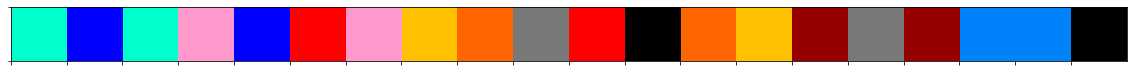

In [39]:
# Test out our colormap
col = sns.color_palette([color_lookup[d] for d in finishing_order])
sns.palplot(col)

# Plot
Adapted from an [official example](https://seaborn.pydata.org/examples/kde_ridgeplot.html)

Text(0.5, 0.98, 'Laptime distributions for the 2020 Hungarian Grand Prix')

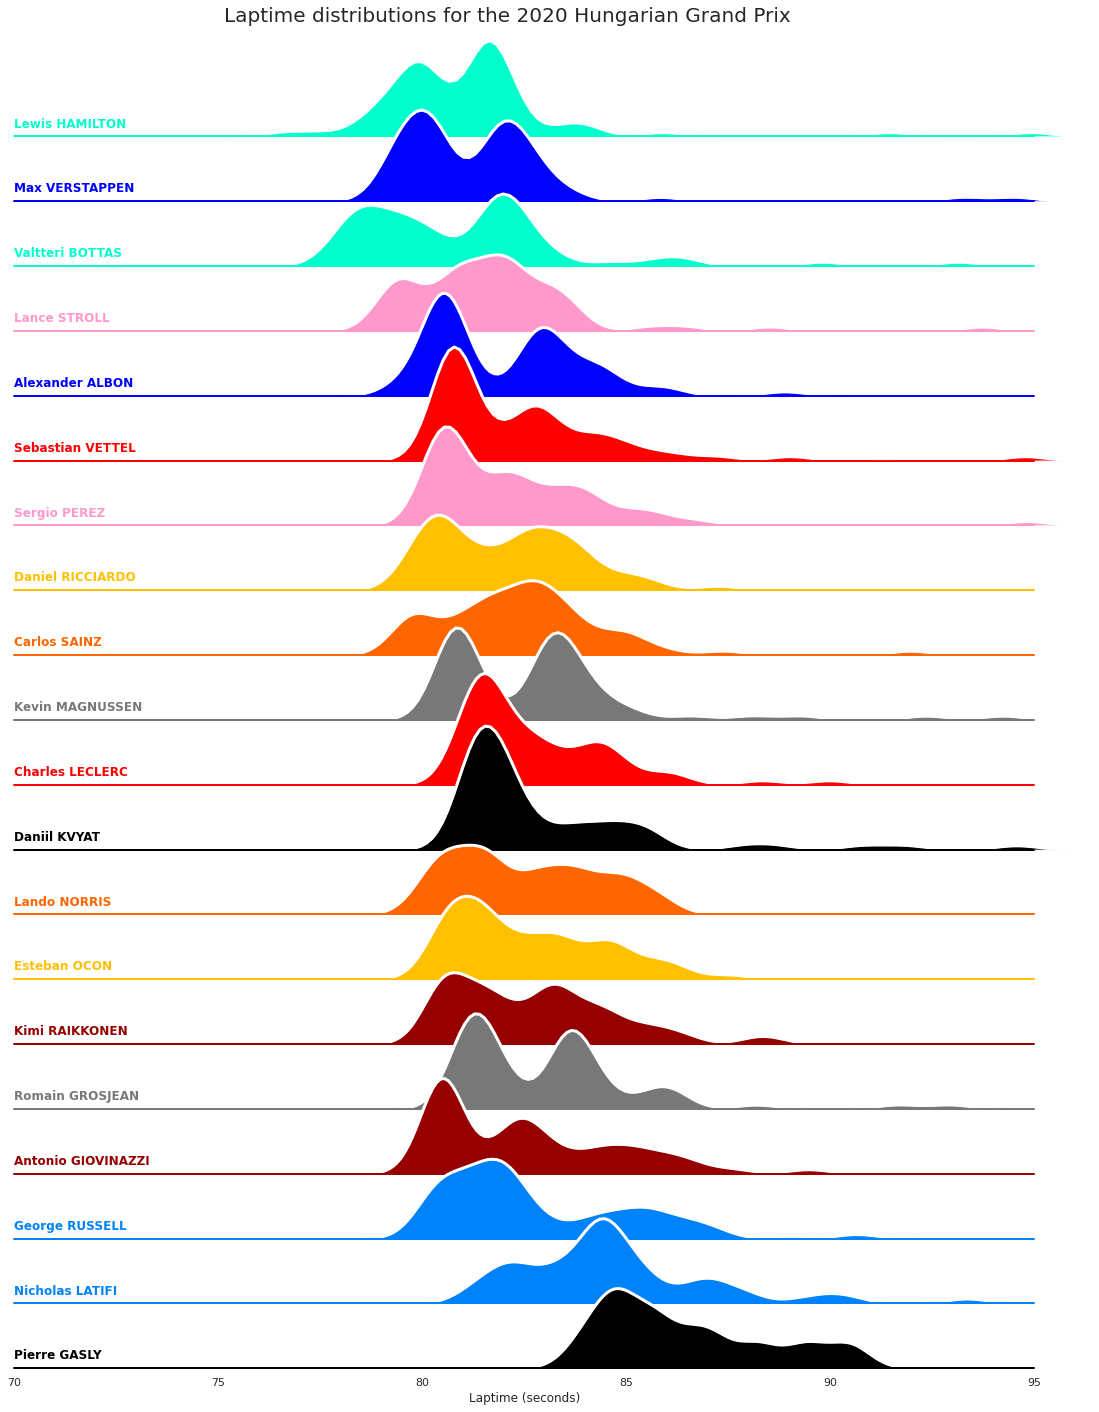

In [40]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

g = sns.FacetGrid(df,
                  row='variable', # <-- "driver" column (was lazy and didn't rename)
                  hue='variable',
                  aspect=15,
                  height=1,
                  palette=col,
                  row_order=finishing_order,
                  hue_order=finishing_order)
# Map a KDE plot for each driver
g.map(sns.kdeplot, 'laptime_seconds', clip_on=False, shade=True, alpha=1, bw=0.5)
# Add a white outline
g.map(sns.kdeplot, 'laptime_seconds', clip_on=False, color='w', alpha=1, lw=3, bw=0.5)
# Add a solid horizontal line
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .1, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "variable")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.5)

# Remove axes details that don't play well with overlap
g.set(yticks=[])
g.despine(bottom=True, left=True)

g.set_titles("")
g.set(xlim=(70,95))
g.set_axis_labels('Laptime (seconds)')
plt.suptitle('Laptime distributions for the 2020 Hungarian Grand Prix', fontsize=20)